<a href="https://colab.research.google.com/github/Edenshmuel/ICU_Nutrition_ML/blob/main/Neural_Network_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Loading Preprocessing Pipeline from GitHub**

In [1]:
import requests
import nbformat
from nbconvert import PythonExporter

url = "https://raw.githubusercontent.com/Edenshmuel/ICU_Nutrition_ML/refs/heads/main/Pipeline.ipynb"

response = requests.get(url)

if response.status_code == 200:
    notebook_content = response.text
    notebook = nbformat.reads(notebook_content, as_version=4)
    python_exporter = PythonExporter()
    source, _ = python_exporter.from_notebook_node(notebook)
    exec(source)

    print("✅ Pipeline loaded successfully from GitHub!")
else:
    print(f"❌ Failed to fetch notebook: {response.status_code}")

✅ Pipeline loaded successfully from GitHub!


**Importing the Data**

Importing Necessary Libraries

In [2]:
import copy
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

Cloning the Project Repository

In [3]:
!git clone https://github.com/Edenshmuel/ICU_Nutrition_ML.git

fatal: destination path 'ICU_Nutrition_ML' already exists and is not an empty directory.


Loading the Dataset

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/Edenshmuel/ICU_Nutrition_ML/refs/heads/main/Food_and_Nutrition__.csv")
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,Calories,Carbohydrates,Fiber,Fat,Breakfast Suggestion,Lunch Suggestion,Dinner Suggestion,Snack Suggestion,Disease
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,2020,250,30.0,60,Oatmeal with berries and nuts,Grilled chicken salad with mixed greens,Salmon with roasted vegetables,Greek yogurt with fruit,Weight Gain
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,1480,200,24.0,40,Tofu scramble with veggies,Lentil soup with whole wheat bread,Vegetable stir-fry with brown rice,Apple with almond butter,"Weight Gain, Hypertension, Heart Disease"
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,2185,300,36.0,65,Tofu and veggie breakfast burrito,Black bean burger on a whole wheat bun,Lentil and vegetable curry,Trail mix,Weight Gain
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,2680,350,42.0,80,Greek yogurt with granola and fruit,Chicken and vegetable stir-fry,Turkey chili with brown rice,Banana with peanut butter,Weight Gain
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,1815,250,30.0,55,Scrambled eggs with whole wheat toast and avocado,Quinoa salad with chickpeas and vegetables,Vegetarian chili with cornbread,Fruit and nut mix,Weight Gain


**Data Preprocessing**

Categorize Features: Numerical, Categorical, and Skewed Columns

In [5]:
numerical_features = ["Ages", "Height", "Weight", "Fiber"]
categorical_features = ["Gender", "Dietary Preference"]

Features identified as right-skewed from EDA. Applying log transformation

In [6]:
right_skewed_features = ["Fat", "Sodium"]

To ensure consistency, we remove diseases that appear only once, as they cause mismatched features between training and test sets and provide no learning value for the model

In [7]:
from collections import Counter

df["Disease_Split"] = df["Disease"].astype(str).str.split(", ")

all_diseases = [disease for sublist in df["Disease_Split"] for disease in sublist]
disease_counts = Counter(all_diseases)

print("Single disease count:")
for disease, count in disease_counts.items():
    print(f"{disease}: {count}")

rare_diseases = [disease for disease, count in disease_counts.items() if count < 2]

print("\nRare diseases (appear less than 2 times):")
print(rare_diseases)

Single disease count:
Weight Gain: 1664
Hypertension: 292
Heart Disease: 289
Kidney Disease: 189
Diabetes: 66
Acne: 66
Weight Loss: 1

Rare diseases (appear less than 2 times):
['Weight Loss']


In [8]:
df = df[~df["Disease"].str.contains("Weight Loss", na=False)]

In [9]:
Multy_categorical_features = ["Disease"]

In [10]:
X = df.drop(columns=["Daily Calorie Target", "Protein", "Carbohydrates"])
y = df[["Daily Calorie Target", "Protein", "Carbohydrates"]]

Prevent Data Leakage: Remove Columns That Contain Target Information

In [11]:
X = df.drop(columns=["Calories"])

Removing Non-Contributing Columns

In [12]:
columns_to_remove = ["Sugar", "Breakfast Suggestion", "Lunch Suggestion",
                     "Dinner Suggestion", "Snack Suggestion"]

X = df.drop(columns=columns_to_remove)

Analysis showed that keeping 'Sodium' and 'Fiber' significantly reduced the model's error, so I decided to keep them

**Splitting the Data**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
print(f"Y Train: {y_train.shape}, Y Test: {y_test.shape}")

Train: (1357, 15), Test: (340, 15)
Y Train: (1357, 3), Y Test: (340, 3)


**Apply the Pipeline**

In [14]:
preprocessor = create_preprocessor(numerical_features,categorical_features, right_skewed_features,
                                   Multy_categorical_features)


In [15]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [16]:
print(f"✅ Training Data Processed: {X_train_transformed.shape} (Rows, Features)")
print(f"✅ Test Data Processed: {X_test_transformed.shape} (Rows, Features)")

✅ Training Data Processed: (1357, 19) (Rows, Features)
✅ Test Data Processed: (340, 19) (Rows, Features)


**Baseline Model**

A baseline model is created by randomly shuffling the target values to compare the neural network's performance against a naive prediction

In [17]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [18]:
y_test_copy = np.array(copy.deepcopy(y_test))

np.random.shuffle(y_test_copy)

random_baseline_mae = mean_absolute_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_mse = mean_squared_error(y_test, y_test_copy, multioutput="raw_values")
random_baseline_rmse = np.sqrt(random_baseline_mse)
random_baseline_r2 = r2_score(y_test, y_test_copy, multioutput="raw_values")

print(f"Random Baseline MAE per target: {random_baseline_mae}")
print(f"Average Random Baseline MAE: {random_baseline_mae.mean():.2f}")

print(f"Random Baseline MSE per target: {random_baseline_mse}")
print(f"Average Random Baseline MSE: {random_baseline_mse.mean():.2f}")

print(f"Random Baseline RMSE per target: {random_baseline_rmse}")
print(f"Average Random Baseline RMSE: {random_baseline_rmse.mean():.2f}")

print(f"Random Baseline R² per target: {random_baseline_r2}")
print(f"Average Random Baseline R²: {random_baseline_r2.mean():.2f}")

Random Baseline MAE per target: [626.05882353  59.88823529  78.59411765]
Average Random Baseline MAE: 254.85
Random Baseline MSE per target: [654721.92941176   5858.39411765   9899.08823529]
Average Random Baseline MSE: 223493.14
Random Baseline RMSE per target: [809.14889199  76.5401471   99.49416182]
Average Random Baseline RMSE: 328.39
Random Baseline R² per target: [-1.00366349 -0.9662656  -0.98967552]
Average Random Baseline R²: -0.99


**Neural Network Model**

This section defines and trains a neural network using K-Fold cross-validation. The model includes batch normalization, dropout, L2 regularization, and an exponentially decaying learning rate. The Mean Absolute Error (MAE) is calculated for each fold and averaged across all folds



In [19]:
#!pip install scikit-learn==1.3.1

In [20]:
!pip install --upgrade scikit-learn scikeras --quiet

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [22]:
y_train_np = y_train.to_numpy()

In [23]:
lr_schedule = ExponentialDecay(initial_learning_rate=0.01, decay_steps=1000, decay_rate=0.96, staircase=True)

In [24]:
def build_model():
    model = Sequential([
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_transformed.shape[1],)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),

        Dense(y_train.shape[1], activation='linear')])

    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [25]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

mae_per_column = []

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

for train_idx, val_idx in kfold.split(X_train_transformed):
    X_train_fold, X_val_fold = X_train_transformed[train_idx], X_train_transformed[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    model = build_model()

    history = model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=16, verbose=1,
                        validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping])

    y_val_pred = model.predict(X_val_fold)

    fold_mae_per_column = mean_absolute_error(y_val_fold, y_val_pred, multioutput="raw_values")

    mae_per_column.append(fold_mae_per_column)

    print(f"MAE per column in the current fold: {fold_mae_per_column}")

mae_per_column = np.array(mae_per_column)

mean_mae_per_column = mae_per_column.mean(axis=0)

print("\nAverage MAE per column:")
for i, col_name in enumerate(["Calories", "Carbohydrates", "Protein"]):
    print(f"{col_name}: {mean_mae_per_column[i]:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1833420.2500 - mae: 882.6155 - val_loss: 1768591.6250 - val_mae: 842.4438
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1756653.7500 - mae: 851.6582 - val_loss: 1638580.1250 - val_mae: 783.5590
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1577617.6250 - mae: 778.2429 - val_loss: 1348729.0000 - val_mae: 717.3760
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1345695.3750 - mae: 709.8433 - val_loss: 951674.3750 - val_mae: 613.4452
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1116026.5000 - mae: 641.3443 - val_loss: 883433.4375 - val_mae: 578.9284
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 830420.6250 - mae: 551.7700 - val_loss: 703112.1875 - val_mae: 502.1164
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 564520.4375 - mae: 444.6390 - val_loss: 382059.2812 - val_mae: 365.1549
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 360999.1562 - mae: 350.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1848951.0000 - mae: 885.7141 - val_loss: 1736369.2500 - val_mae: 841.1459
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1794482.1250 - mae: 858.7435 - val_loss: 1578074.3750 - val_mae: 768.9757
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1659411.2500 - mae: 793.9570 - val_loss: 1303221.8750 - val_mae: 698.3083
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1362674.0000 - mae: 711.8126 - val_loss: 874743.4375 - val_mae: 598.2651
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1090459.2500 - mae: 632.2917 - val_loss: 592304.0625 - val_mae: 494.1664
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 817222.4375 - mae: 544.6746 - val_loss: 390408.7500 - val_mae: 389.1572
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 574944.5625 - mae: 451.9611 - val_loss: 338360.0625 - val_mae: 345.7336
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 362039.6875 - mae: 351.5552 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1832068.5000 - mae: 883.5057 - val_loss: 1775110.7500 - val_mae: 846.1991
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1735728.5000 - mae: 845.5225 - val_loss: 1594544.7500 - val_mae: 771.6728
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1624699.1250 - mae: 789.4149 - val_loss: 1314412.0000 - val_mae: 694.9755
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1361672.7500 - mae: 709.0558 - val_loss: 868786.6250 - val_mae: 607.5093
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1071565.2500 - mae: 628.1321 - val_loss: 670976.3750 - val_mae: 515.3130
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 835469.6250 - mae: 549.1488 - val_loss: 580570.1250 - val_mae: 463.8846
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 563650.7500 - mae: 445.7660 - val_loss: 297062.5938 - val_mae: 324.7990
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 353639.3750 - mae: 350.6614 - val_l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1923234.7500 - mae: 904.1672 - val_loss: 1708711.1250 - val_mae: 832.7166
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1802338.2500 - mae: 864.6049 - val_loss: 1561394.2500 - val_mae: 766.1498
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1624377.5000 - mae: 790.6970 - val_loss: 1275422.2500 - val_mae: 701.5838
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1363735.1250 - mae: 715.4872 - val_loss: 990773.1250 - val_mae: 634.5957
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1079612.3750 - mae: 632.2876 - val_loss: 706817.0000 - val_mae: 514.7922
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 839361.7500 - mae: 551.5004 - val_loss: 405854.8750 - val_mae: 389.8665
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 552915.1875 - mae: 443.6613 - val_loss: 370986.1875 - val_mae: 363.1080
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 356871.1875 - mae: 349.4071 - val_l

**Plot Training vs. Validation Loss**

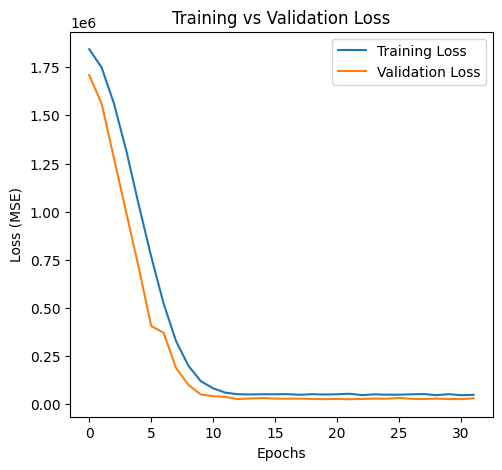

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()

**Model Evaluation**

In [27]:
y_test_pred = model.predict(X_test_transformed)

test_mae = mean_absolute_error(y_test, y_test_pred, multioutput="raw_values")
test_mse = mean_squared_error(y_test, y_test_pred, multioutput="raw_values")
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred, multioutput="raw_values")

print("\n**Model Performance Comparison vs. Baseline**")

print("\nMAE - Mean Absolute Error:")
print(f"Random Baseline: {np.round([631.62, 58.01, 82.83], 2)}")
print(f"Model Performance: {np.round(test_mae, 2)}")

print("\nMSE-Mean Squared Error:")
print(f"Random Baseline: {np.round([637653.03, 5360.05, 10613.26], 2)}")
print(f"Model Performance: {np.round(test_mse, 2)}")

print("\nRMSE - Root Mean Squared Error:")
print(f"Random Baseline: {np.round([798.53, 73.21, 103.02], 2)}")
print(f"Model Performance: {np.round(test_rmse, 2)}")

print("\nR² - Proportion of Variance Explained by the Model:")
print(f"Random Baseline: {np.round([-0.94, -0.94, -1.03], 2)}")
print(f"Model Performance: {np.round(test_r2, 2)}")

print("\nAverage Metric Comparison Between Model and Baseline:")
print(f"Average Random Baseline MAE: {np.round(257.49, 2)}, Model MAE: {np.round(test_mae.mean(), 2)}")
print(f"Average Random Baseline MSE: {np.round(217875.45, 2)}, Model MSE: {np.round(test_mse.mean(), 2)}")
print(f"Average Random Baseline RMSE: {np.round(324.92, 2)}, Model RMSE: {np.round(test_rmse.mean(), 2)}")
print(f"Average Random Baseline R²: {np.round(-0.97, 2)}, Model R²: {np.round(test_r2.mean(), 2)}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

**Model Performance Comparison vs. Baseline**

MAE - Mean Absolute Error:
Random Baseline: [631.62  58.01  82.83]
Model Performance: [203.95  25.54  27.36]

MSE-Mean Squared Error:
Random Baseline: [637653.03   5360.05  10613.26]
Model Performance: [86032.11   878.11  1460.89]

RMSE - Root Mean Squared Error:
Random Baseline: [798.53  73.21 103.02]
Model Performance: [293.31  29.63  38.22]

R² - Proportion of Variance Explained by the Model:
Random Baseline: [-0.94 -0.94 -1.03]
Model Performance: [0.74 0.71 0.71]

Average Metric Comparison Between Model and Baseline:
Average Random Baseline MAE: 257.49, Model MAE: 85.61000061035156
Average Random Baseline MSE: 217875.45, Model MSE: 29457.0390625
Average Random Baseline RMSE: 324.92, Model RMSE: 120.38999938964844
Average Random Baseline R²: -0.97, Model R²: 0.7200000286102295


**Tracking Model Performance Across Runs**

In [28]:
import os

# Define the file to store results
results_file = "model_results.csv"

current_results = {
    "MAE": np.round(test_mae.mean(), 2),
    "MSE": np.round(test_mse.mean(), 2),
    "RMSE": np.round(test_rmse.mean(), 2),
    "R2": np.round(test_r2.mean(), 2)}

if os.path.exists(results_file):
    previous_results = pd.read_csv(results_file)

    std_results = previous_results.std().round(2)
    mean_results = previous_results.mean().round(2)

    print("\nComparison with Previous Run:")
    last_run = previous_results.iloc[-1]
    for metric in current_results:
        prev_value = last_run[metric]
        current_value = current_results[metric]
        change = current_value - prev_value
        print(f"{metric}: {current_value} (Previous: {prev_value}, Change: {change:+.2f})")

    print("\nHistorical Performance Stats:")
    for metric in current_results:
        print(f"{metric}: Mean = {mean_results[metric]}, Std = {std_results[metric]}")

else:
    print("\nNo previous results found. This is the first recorded run.")

# Append new results to the file
new_entry = pd.DataFrame([current_results])
new_entry.to_csv(results_file, mode='a', header=not os.path.exists(results_file), index=False)

print("\nResults saved successfully!")


Comparison with Previous Run:
MAE: 85.61000061035156 (Previous: 82.99, Change: +2.62)
MSE: 29457.0390625 (Previous: 30806.7, Change: -1349.66)
RMSE: 120.38999938964844 (Previous: 120.46, Change: -0.07)
R2: 0.7200000286102295 (Previous: 0.75, Change: -0.03)

Historical Performance Stats:
MAE: Mean = 82.99, Std = nan
MSE: Mean = 30806.7, Std = nan
RMSE: Mean = 120.46, Std = nan
R2: Mean = 0.75, Std = nan

Results saved successfully!
